# Introduction

In the realm of data analysis, accurately forecasting future values of time series data is critical for decision-making across various industries, from finance to weather prediction. My primary motivation for this project was to tackle the complexities associated with seasonal time series data which often exhibit patterns that repeat over time. By developing a robust model capable of accounting for these seasonal variations. 

this project involves analyzing a dataset with evident seasonal trends, doing a thorough examination and transformation to achieve stationarity which is prerequisite for many time series modeling techniques. I started on this project to explore and implement advanced modeling techniques, particularly the Seasonal Autoregressive Integrated Moving Average (SARIMA) model, which is well-suited for handling such data. My goal is to identify the most effective SARIMA model parameters that could accurately capture the underlying patterns of the data, leading to improved forecast accuracy and insightful analysis.

# Dataset

https://www.kaggle.com/datasets/vanvalkenberg/historicalweatherdataforindiancities/Chennai_1990_2022_Madras.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm


In [2]:
df_temp = pd.read_csv("Chennai.csv")
df_temp.head()


,time,tavg,tmin,tmax,prcp
0,01-01-1990,25.2,22.8,28.4,0.5
1,02-01-1990,24.9,21.7,29.1,0.0
2,03-01-1990,25.6,21.4,29.8,0.0
3,04-01-1990,25.7,NaN,28.7,0.0
4,05-01-1990,25.5,20.7,28.4,0.0


In [3]:
df_temp['time'] = pd.to_datetime(df_temp['time'], format='%d-%m-%Y')

In [4]:
df = df_temp[['time', 'tavg']]
df.head()


,time,tavg
0,1990-01-01,25.2
1,1990-01-02,24.9
2,1990-01-03,25.6
3,1990-01-04,25.7
4,1990-01-05,25.5


In [5]:
df['time'] = pd.to_datetime(df['time'])
df['Year'] = df['time'].dt.year
df['Month'] = df['time'].dt.month
df = df.groupby(['Year', 'Month'])['tavg'].mean().round(2).reset_index()
df.head()

,Year,Month,tavg
0,1990,1,24.21
1,1990,2,26.83
2,1990,3,28.66
3,1990,4,30.38
4,1990,5,29.85


### We will calculate the monthly average temperatures and use these figures for our analysis.

In [6]:
df.isna().sum()


Year     0
Month    0
tavg     0
dtype: int64

# Time Series plot by average temperature by month

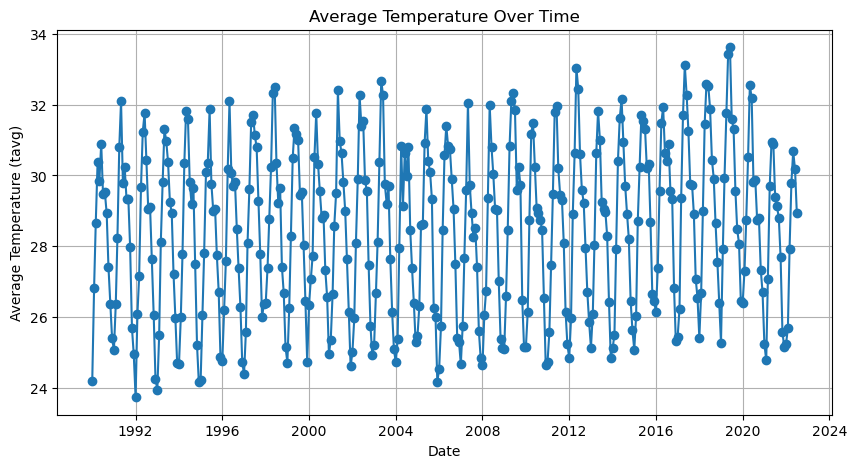

In [7]:
df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
# Plotting

plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['tavg'], marker='o')
plt.title('Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Average Temperature (tavg)')
plt.grid(True)
plt.show()


### Visualizing the Time series plot

In [8]:
# Dropping the 'Date' column
df = df.drop(columns=['Date'])
df.head()


,Year,Month,tavg
0,1990,1,24.21
1,1990,2,26.83
2,1990,3,28.66
3,1990,4,30.38
4,1990,5,29.85


# Sesonality 

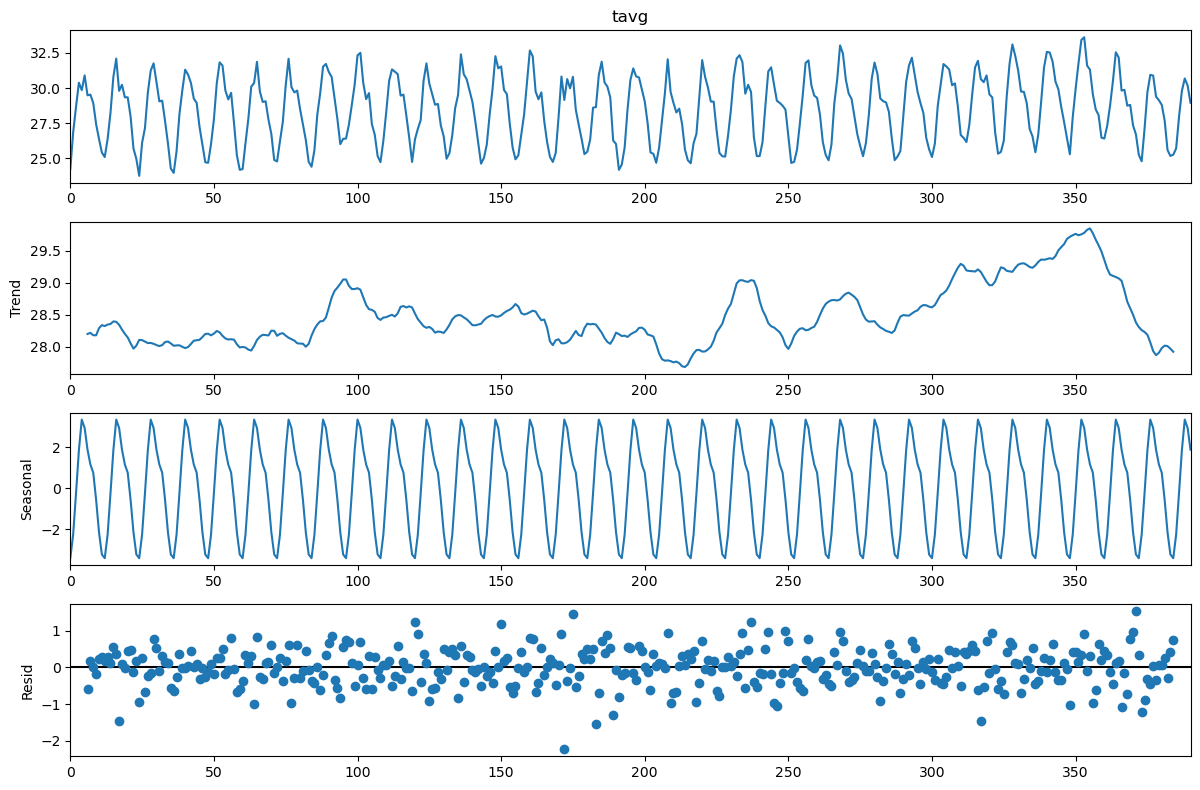

In [9]:
result = seasonal_decompose(df['tavg'], model='additive', period=12)
fig = result.plot()
fig.set_size_inches((12, 8))
fig.tight_layout()
plt.show()

### The decomposition of the original time series clearly reveals a seasonal component in the data, affirming its cyclical nature throughout the year. This analysis confirms the presence of seasonality in the dataset.

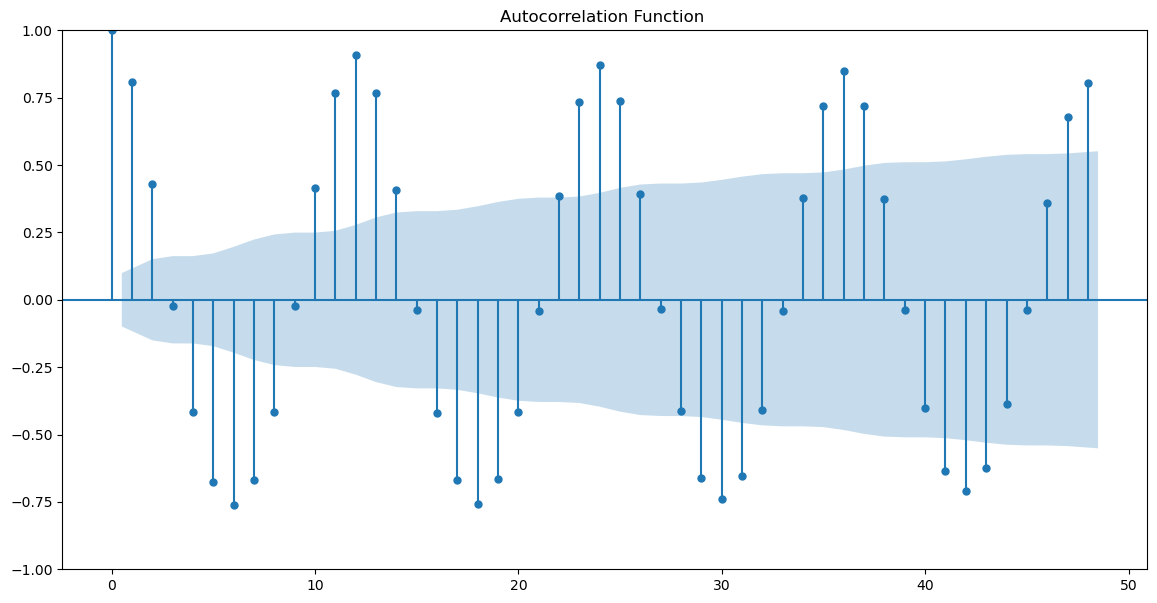

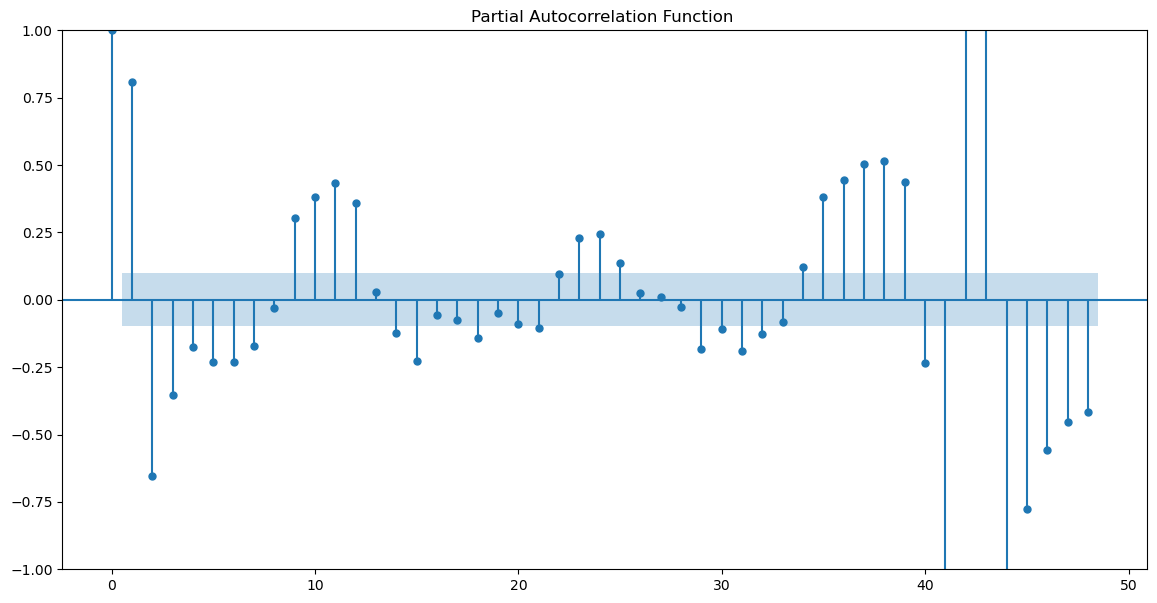

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF for the differenced series
plt.figure(figsize=(14, 7))
plot_acf(df['tavg'], lags=48, ax=plt.gca())
plt.title('Autocorrelation Function ')
plt.show()

# Plotting the PACF for the differenced series
plt.figure(figsize=(14, 7))
plot_pacf(df['tavg'], lags=48, ax=plt.gca())
plt.title('Partial Autocorrelation Function ')
plt.show()

# Stationarity Check

In [11]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(df['tavg'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] < 0.05:
    print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.")


ADF Statistic: -2.660023
p-value: 0.081215
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.


### Since the series is not stationary I will do diffrencing 

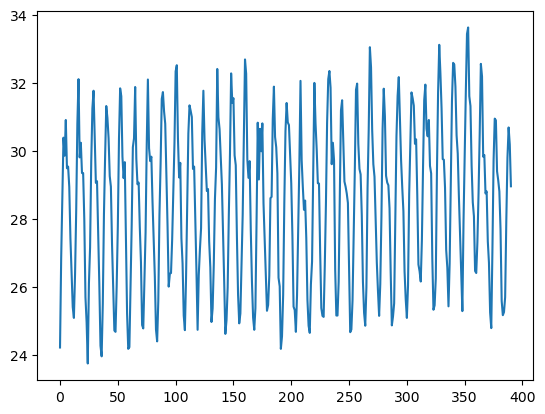

In [12]:
plt.plot(df['tavg'])

#  Differencing 

In [13]:
# Apply differencing to the 'tavg' column
df['tavg_diff'] = df['tavg'].diff()

# Drop the NA values that are the result of differencing
df = df.dropna()


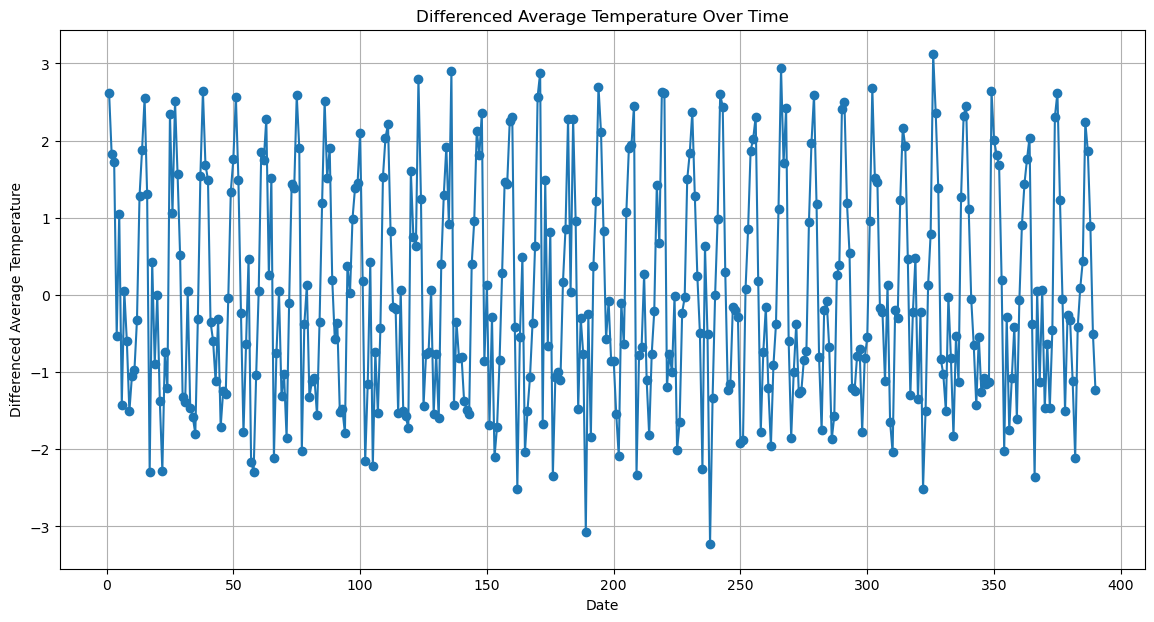

In [14]:
# Plot the differenced data
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['tavg_diff'], marker='o')
plt.title('Differenced Average Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Differenced Average Temperature')
plt.grid(True)
plt.show()

### Visualizng the Differenced Time Series plot

In [15]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(df['tavg_diff'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] < 0.05:
    print("Reject the null hypothesis (H0), the data does not have a unit root and is stationary.")
else:
    print("Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.")


ADF Statistic: -7.303885
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


### After performing the differencing operation we got the ADF test result as stationary.

# ACF and PACF plots

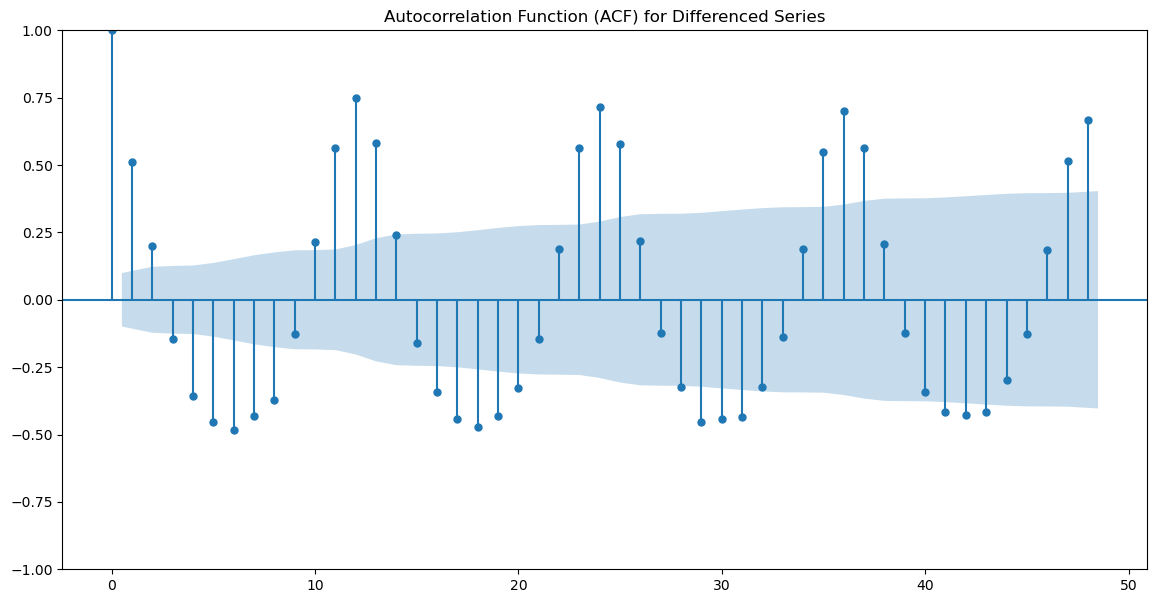

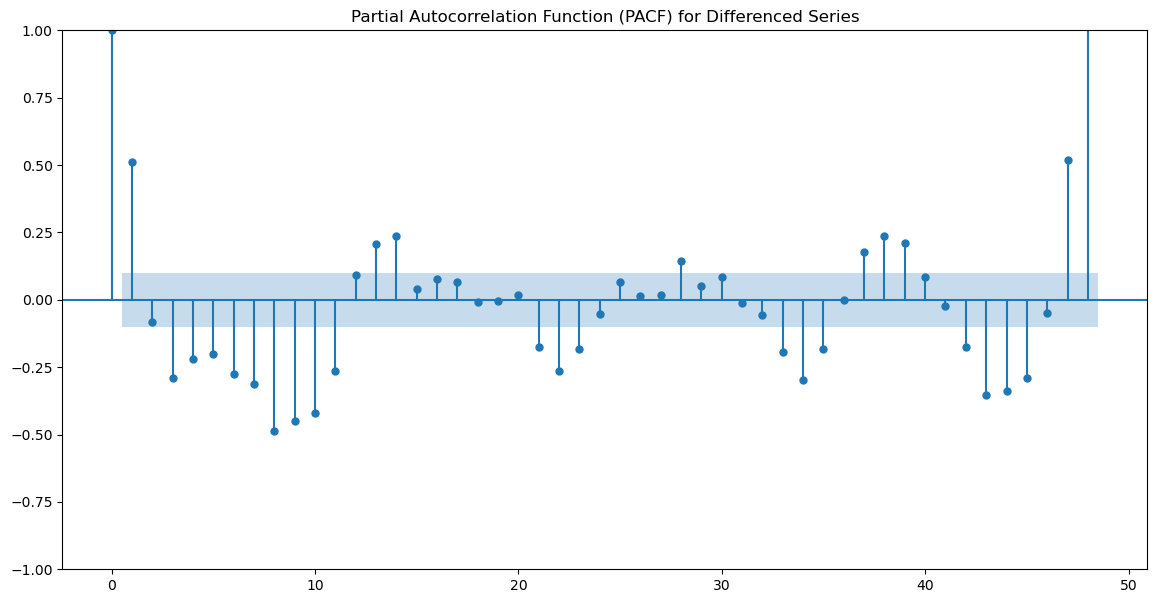

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF for the differenced series
plt.figure(figsize=(14, 7))
plot_acf(df['tavg_diff'], lags=48, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) for Differenced Series')
plt.show()

# Plotting the PACF for the differenced series
plt.figure(figsize=(14, 7))
plot_pacf(df['tavg_diff'], lags=48, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) for Differenced Series')
plt.show()


### For ACF We observe 3 or 4 significant lags for non seasonal component and about 3 to 4 lags in seasonal component and for PACF 1 significant lags for non seasonal component and around 4 significant lags for seasonal component.


# Train Test Split

In [17]:
length = len(df)
df_train = df.head(length - 30)
df_test = df.tail(30)

# Best SARIMA Model

### Based on what we observed in the ACF and PACF plot let us form a loop with a range of values for the parameters in the SARIMA model which will help us determine our best model with the lowest aic score. Since we observed 4 significant lags in seasonal component and 3 to 4 significant lags in non seasonal component

### p=1 to 4
### q=1 to 4
### P= 1 to 4
### Q=1 to 4
### S=12

In [18]:
best_aic = float('inf')
best_params = None
loop_counter = 0

# Loop over the range of parameters
for p in range(1, 4):
    for d in [1]:  # fixed depth as 1 since differencing of 1 was sufficient to make the series stationary
        for q in range(1, 4):
            for P in range(1, 4):
                for D in [1]:  
                    for Q in range(1, 4):
                        loop_counter += 1  # Increment the loop counter
                        try:
                            # Define and fit the model
                            model = SARIMAX(df_train['tavg_diff'],
                                            order=(p, d, q),
                                            seasonal_order=(P, D, Q, 12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                            results = model.fit()

                            # Check if the current model's AIC is better (lower)
                            if results.aic < best_aic:
                                best_aic = results.aic
                                best_params = (p, d, q, P, D, Q)
                            
                        except Exception as e:
                            # Catch exceptions, which are common in model fitting
                            print(f"An error occurred for parameters {(p, d, q, P, D, Q)}: {e}")

# After all iterations, print the best AIC and parameters
print(f"Best Parameters: {best_params}")
print(f"Best AIC: {best_aic}")
print(f"Total loops completed: {loop_counter}")


Best Parameters: (1, 1, 2, 2, 1, 3)
Best AIC: 582.2106606807444
Total loops completed: 81


### After 81 different combinations from the given range we got the best parameters as (1, 1, 2, 2, 1, 3) with an AIC 582.2106606807444


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q, P, D, Q, s = 1, 1, 2, 2, 1, 3, 12

# Define the model with the adjusted parameters
adjusted_model = SARIMAX(df_train['tavg_diff'],
                         order=(p, d, q),
                         seasonal_order=(P, D, Q, s),
                         enforce_stationarity=False,
                         enforce_invertibility=False)

# Fit the model
adjusted_results = adjusted_model.fit()

# Conduct diagnostic checks on the adjusted model
print(adjusted_results.summary())



                                         SARIMAX Results                                          
Dep. Variable:                                  tavg_diff   No. Observations:                  360
Model:             SARIMAX(1, 1, 2)x(2, 1, [1, 2, 3], 12)   Log Likelihood                -282.105
Date:                                    Thu, 02 May 2024   AIC                            582.211
Time:                                            23:01:45   BIC                            615.782
Sample:                                                 0   HQIC                           595.634
                                                    - 360                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2395      0.069      3.468      0

# Residual Analysis

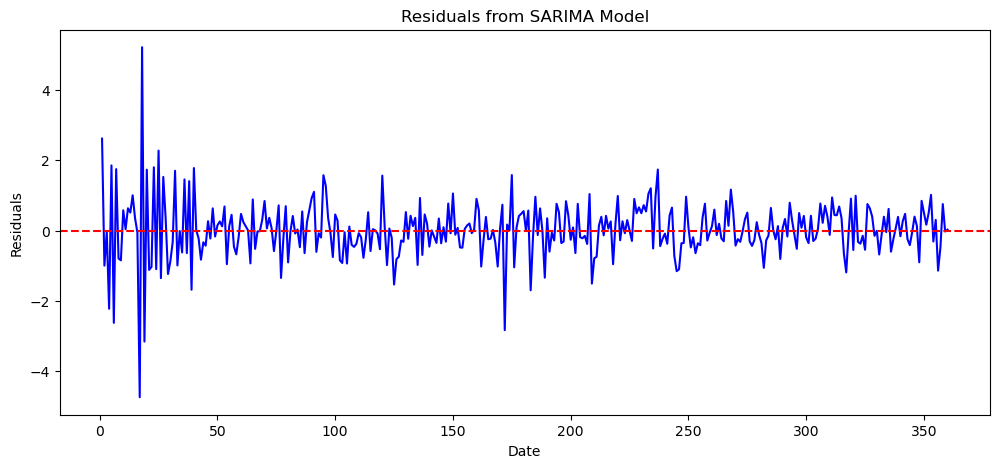

<Figure size 1200x500 with 0 Axes>

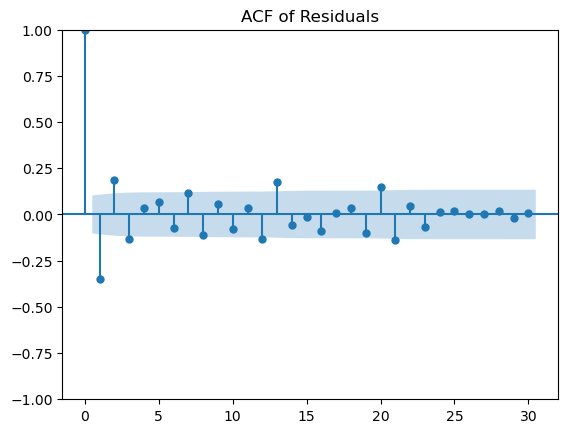

<Figure size 1200x500 with 0 Axes>

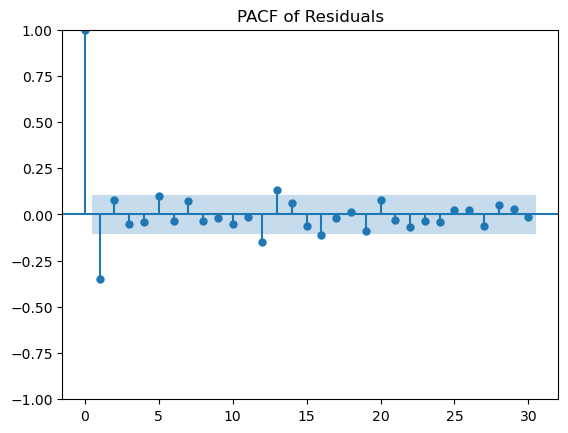

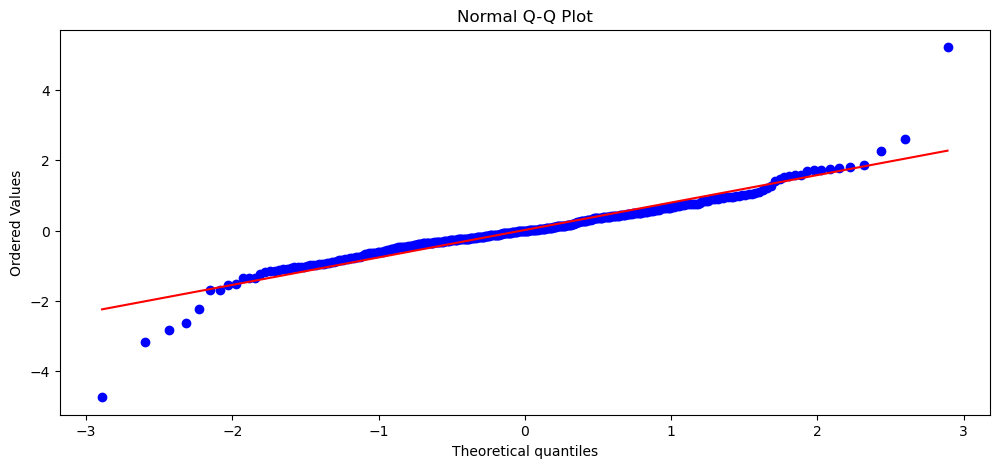

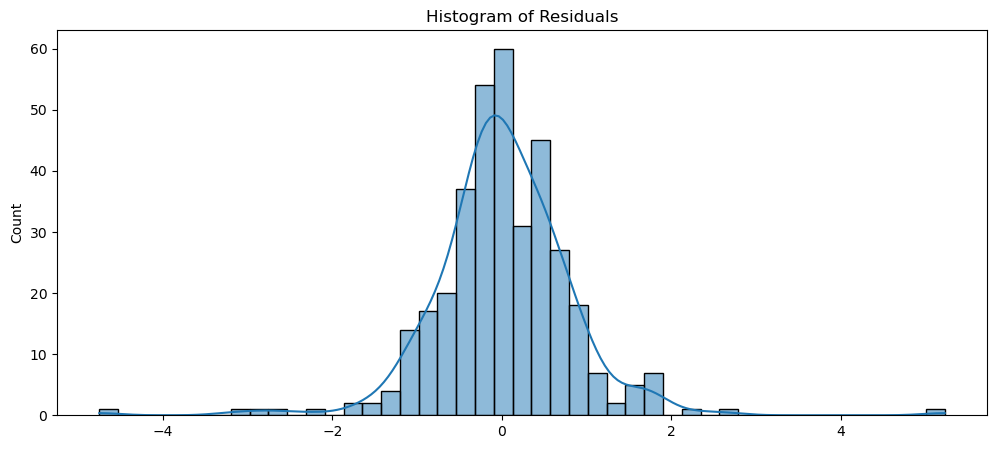

Shapiro-Wilk Test: Statistics=0.914070188999176, p-value=1.8269673968118738e-13
Reject the null hypothesis (H0), the data is not normally distributed.


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro, probplot

# Extract the residuals
residuals = adjusted_results.resid

# Plotting the residuals
plt.figure(figsize=(12, 5))
plt.plot(residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals from SARIMA Model')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

# Plotting the ACF of residuals
plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=30)
plt.title('ACF of Residuals')
plt.show()

# Plotting the PACF of residuals
plt.figure(figsize=(12, 5))
plot_pacf(residuals, lags=30)
plt.title('PACF of Residuals')
plt.show()

# Normal Q-Q plot
plt.figure(figsize=(12, 5))
probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')
plt.show()

# Histogram of residuals
plt.figure(figsize=(12, 5))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# Calculate the Shapiro-Wilk test on the residuals
shapiro_test = shapiro(residuals)
shapiro_stat, shapiro_p_value = shapiro_test

# Interpret the results
alpha = 0.05
if shapiro_p_value > alpha:
    conclusion = "Fail to reject the null hypothesis (H0), the data is normally distributed."
else:
    conclusion = "Reject the null hypothesis (H0), the data is not normally distributed."

# Print the results
print(f"Shapiro-Wilk Test: Statistics={shapiro_stat}, p-value={shapiro_p_value}")
print(conclusion)



### The residuals appear to be randomly distributed without any obvious patterns

### For ACF and PACF plots of residuals I can see some significant lags.

###  The residuals lie mostly along the red line indicating that the residuals are approximately normally distributed and there are slight deviations at the tails on both ends which tells some outliers are present.

### The histogram is almost normally distibuted but bit of right-skewed.

       lb_stat     lb_pvalue
1    44.076244  3.158308e-11
2    57.093365  4.002519e-13
3    63.554092  1.022339e-13
4    64.066916  4.045759e-13
5    65.704860  8.003139e-13
6    67.672295  1.226128e-12
7    72.490677  4.629615e-13
8    76.972649  1.984447e-13
9    78.126777  3.803387e-13
10   80.376128  4.236468e-13
11   80.845047  1.012746e-12
12   87.332755  1.617815e-13
13   99.147526  2.426364e-15
14  100.299547  4.155092e-15
15  100.382218  1.104202e-14
16  103.309079  8.276395e-15
17  103.331810  2.138702e-14
18  103.846576  4.348491e-14
19  107.708232  2.104262e-14
20  116.163701  1.457291e-15


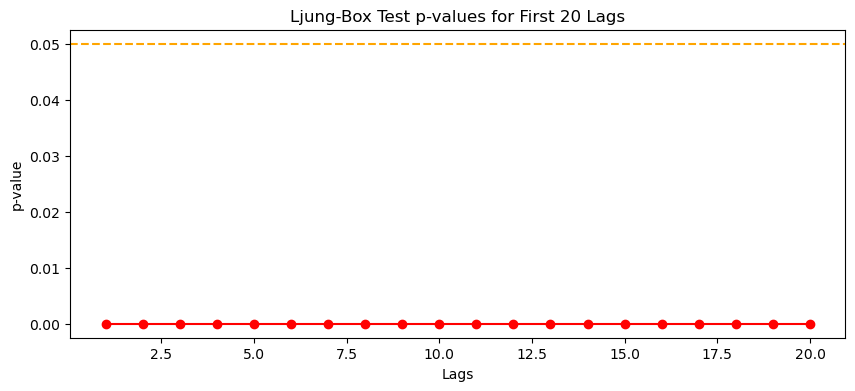

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
import statsmodels.api as sm

ljungbox_results = acorr_ljungbox(residuals, lags=20, return_df=True)
# Print the results
print(ljungbox_results)

# Plotting the Ljung-Box test p-values
plt.figure(figsize=(10, 4))
plt.plot(ljungbox_results['lb_pvalue'], marker='o', linestyle='-', color='red')
plt.title('Ljung-Box Test p-values for First 20 Lags')
plt.xlabel('Lags')
plt.ylabel('p-value')
plt.axhline(y=0.05, color='orange', linestyle='--')  # significance line at p = 0.05
plt.show()


### The Ljung-Box test results with extremely low p-values across all lags strongly suggest that the residuals are not independent and show significant autocorrelation.

# Forecasting 

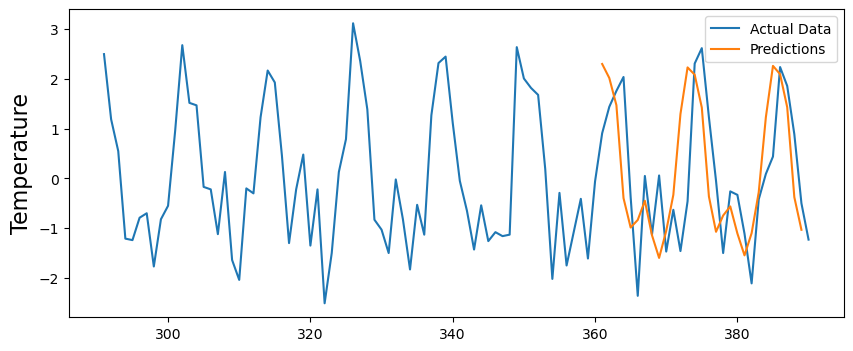

In [33]:
# Forecast future values based on the length of the test dataset
predictions = results.forecast(len(df_test))

predictions = pd.Series(predictions, index=df_test.index)
# Compute residuals as the difference between actual and predicted values
residuals = df_test['tavg_diff'] - predictions
plt.figure(figsize=(10, 4))
# Plot the last 100 points of actual data for comparison
plt.plot(df['tavg_diff'][len(df)-100:len(df)], label='Actual Data')
# Plot the forecasted values
plt.plot(predictions, label='Predictions')
plt.legend(fontsize=10)
plt.ylabel('Temperature', fontsize=16)
plt.show()


### The orange line representing the predictions closely follows the blue line of the actual data, indicating that the SARIMA model is effectively capturing the trend and seasonality in the data.

# Conclusion

### In this comprehensive time series analysis project, we successfully addressed the challenges posed by seasonaldata. Our approach involved several critical steps, starting with verifying the stationarity of the data. We achieved stationarity through appropriate differencing techniques, ensuring a robust foundation for further analysis.

### Our exploration of various SARIMA models was a key aspect of this project. After thorough testing and evaluation, we identified the model with parameters (1, 1, 2, 2, 1, 3) as the most effective, evidenced by its optimal AIC score of 582.211. This model not only outperformed others in terms of fit but also demonstrated its efficiancy in forecasting.

### In conclusion, this project not only showcased the effectiveness in dealing with seasonal time series data but also underscored the importance of selecting appropriate models based on comprehensive evaluation criteria.
